In [32]:
!pip install -q eyewear-counter

In [ ]:
from eyewear_counter import EyewearCounter, YoloDetector, RetinaFaceDetector, EyewearClassifier, generate_report
import pandas as pd
import torch
import seaborn as sns

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [21]:
df = pd.read_csv('https://github.com/qksolov/eyewear-counter/raw/refs/heads/main/assets/example_data.csv', encoding='cp1251', sep=';')
df.head()

,image_url,true_prediction
0,https://postimg.cc/gallery/1Fjybjh,ссылка на галерею
1,https://i.postimg.cc/RhCG7dXx/img01.jpg,0_0_1
2,https://i.postimg.cc/tJrk26MZ/img02.jpg,0_2_0
3,https://i.postimg.cc/jd5ZC8Dz/img03.png,1_1_0
4,https://i.postimg.cc/c1TFxqLx/img04.jpg,0_0_1


In [23]:
urls = df['image_url'].to_list()

In [24]:
model = EyewearCounter(device=device)

In [ ]:
!pip install -q batch-face

In [25]:
# Можно выбрать детектор и классификатор для EyewearCounter
detector = RetinaFaceDetector(device=device)    # требует установки batch_face
# detector = YoloDetector(device=device) используется в модели по умолчанию

# classifier = EyewearClassifier(model_type='mobilenet_v3_large', device=device)
classifier = EyewearClassifier(model_type='resnet18', device=device) # используется в модели по умолчанию

model = EyewearCounter(
    detector=detector,
    classifier=classifier,
    device=device)

In [36]:
predictions, errors_cnt = model.run(
    sources = urls,     # Список URL или путей к изображениям.
    image_size=640,     # Размер для ресайза изображений. Default: 640.
    image_fit=True,     # Сохранять пропорции с padding. Default: True.
    batch_size=4,       # Размер батча. Default: 32.
    max_workers=3,      # Количество worker'ов. Default: 3.
    max_faces=5,        # Максимальное число лиц обнаруживаемых на изображении. Default: 4.
    threshold=0.7       # Порог уверенности детектора в лице. Default: 0.7.
    )

Обработка:   5%|▌         | 1/19 [00:00<00:03,  5.73it/s]

Не удалось загрузить изображение 0 (https://postimg.cc/gallery/1Fjybjh): 'NoneType' object has no attribute 'shape'


Обработка завершена: 100%|██████████| 19/19 [00:02<00:00,  8.29it/s]


In [37]:
print("predictions: \n", predictions)
print("errors_cnt: ", errors_cnt)

predictions: 
 tensor([[0, 0, 0],
        [0, 0, 1],
        [0, 2, 0],
        [1, 1, 0],
        [0, 0, 1],
        [1, 2, 0],
        [0, 1, 0],
        [1, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [0, 0, 1],
        [0, 1, 1],
        [1, 2, 0],
        [1, 0, 0],
        [0, 0, 0],
        [0, 1, 0],
        [0, 1, 0],
        [0, 1, 0],
        [1, 2, 0]], dtype=torch.int32)
errors_cnt:  1


In [ ]:
result_df, summary_df, class_isolation_stats_df = generate_report(
    predictions.cpu(), errors_cnt,
    df_input=df,                # Исходный df
    filename='report.xlsx'      # Имя файла для сохранения отчета
)

Отчёт сохранён в файл: report.xlsx


In [29]:
result_df.head()

,image_url,true_prediction,В очках,Без очков,В солнцезащитных очках
0,https://postimg.cc/gallery/1Fjybjh,ссылка на галерею,0,0,0
1,https://i.postimg.cc/RhCG7dXx/img01.jpg,0_0_1,0,0,1
2,https://i.postimg.cc/tJrk26MZ/img02.jpg,0_2_0,0,2,0
3,https://i.postimg.cc/jd5ZC8Dz/img03.png,1_1_0,1,1,0
4,https://i.postimg.cc/c1TFxqLx/img04.jpg,0_0_1,0,0,1


In [30]:
summary_df

,Описание,Количество,Процент
0,Обработано изображений,18,
1,Не загружено изображений,1,
2,Обнаружено людей,26,
3,,,
4,Изображений без людей,1,5.3%
5,"Изображений, где все люди в очках",3,15.8%
6,"Изображений, где есть человек в очках",7,36.8%
7,"Изображений, где все люди без очков",6,31.6%
8,"Изображений, где есть человек без очков",11,57.9%
9,"Изображений, где все люди в солнцезащитных очках",3,15.8%


In [31]:
class_isolation_stats_df

,Категория,Тип,Количество
0,Очки,Есть другие классы,4
1,Очки,Без других классов,3
2,Без,Есть другие классы,5
3,Без,Без других классов,6
4,Солнце,Есть другие классы,1
5,Солнце,Без других классов,3


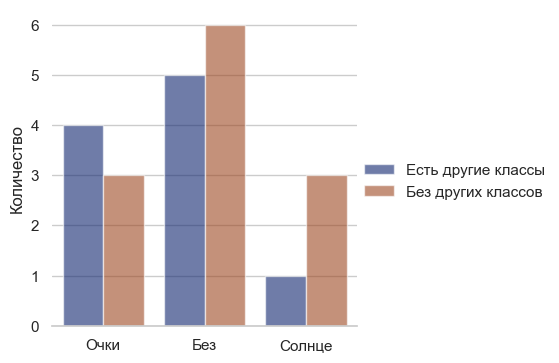

In [32]:
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=class_isolation_stats_df,
    kind="bar",
    x="Категория", y="Количество", hue="Тип",
    errorbar="sd", palette="dark", alpha=.6, height=4
)
g.despine(left=True)
g.set_axis_labels("", "Количество")
g.legend.set_title("")